# CatBoost Baseline Model

Train CatBoost classifier with feature selection based on overfitting analysis.

## 1. Setup

In [2]:
# Core data science libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

# CatBoost specific imports
from catboost import (
    CatBoostClassifier,
    Pool,
    EShapCalcType,
    EFeaturesSelectionAlgorithm,
)

# Model evaluation libraries
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    average_precision_score,
)

# Project utilities
from test_case_fairmoney.utils.constants import (
    PATH_DATA_PROCESSED,
    PATH_MODELS,
    PATH_DATA_COMPRESSED,
)
from test_case_fairmoney.utils.model_validation import plot_AUC, plot_PR
from test_case_fairmoney.utils.model_training import (
    train_catboost_model,
    analyze_feature_importance_cb,
)
from test_case_fairmoney.utils.overfitting_analysis import (
    detect_overfitting_features_catboost,
    plot_overfitting_analysis,
)

# Configuration
pd.set_option("display.max_rows", 300)
pd.set_option("display.max_columns", 800)
warnings.filterwarnings("ignore")

## 2. Load Data

In [3]:
# Load preprocessed datasets
print("Loading preprocessed datasets...")
df_train = pd.read_parquet(PATH_DATA_COMPRESSED / "df_train.parquet")
df_val = pd.read_parquet(PATH_DATA_COMPRESSED / "df_val.parquet")
df_test = pd.read_parquet(PATH_DATA_COMPRESSED / "df_test.parquet")
print(f"✅ Datasets loaded successfully!")
print(f"   Train set: {df_train.shape}")
print(f"   Validation set: {df_val.shape}")
print(f"   Test set: {df_test.shape}")

Loading preprocessed datasets...
✅ Datasets loaded successfully!
   Train set: (600, 27)
   Validation set: (200, 27)
   Test set: (200, 27)


## 3. Define Features

In [4]:
target = "default"
feat_cat = [
    "credit_history",
    "purpose",
    "personal_status",
    "other_debtors",
    "property",
    "installment_plan",
    "housing",
    "foreign_worker",
    "job",
    "gender",
    "telephone_country_code",
    "telephone_mobile_network",
    "is_checking_negative",
]
feat_num = [
    "checking_balance",
    "months_loan_duration",
    "amount",
    "savings_balance",
    "installment_rate",
    "existing_credits",
    "dependents",
    "residence_months",
    "employment_months",
]

In [ ]:
# Handle missing values in categorical features
for feature in feat_cat:
    df_train[feature] = df_train[feature].fillna("Missing")
    df_val[feature] = df_val[feature].fillna("Missing")
    df_test[feature] = df_test[feature].fillna("Missing")

## 4. Create CatBoost Pools

In [6]:
# Create pools with categorical feature specification
train_pool = Pool(
    data=df_train[feat_cat + feat_num],
    label=df_train[target],
    cat_features=feat_cat,
)

test_pool = Pool(
    data=df_test[feat_cat + feat_num],
    label=df_test[target],
    cat_features=feat_cat,
)

val_pool = Pool(
    data=df_val[feat_cat + feat_num],
    label=df_val[target],
    cat_features=feat_cat,
)

## 5. Train Baseline Model (All Features)

In [ ]:
results = train_catboost_model(
    train_pool=train_pool, val_pool=val_pool, test_pool=test_pool, verbose=True
)

model = results["model"]
predictions = results["predictions"]
print("✅ Baseline model trained")

In [8]:
analyze_feature_importance_cb(model=model, pool=train_pool, top_n=10)


📊 TOP 10 MOST IMPORTANT FEATURES
   checking_balance                  23.56
   credit_history                    17.98
   months_loan_duration              11.42
   is_checking_negative               9.57
   installment_plan                   7.01
   other_debtors                      5.05
   property                           4.86
   installment_rate                   3.69
   personal_status                    3.24
   amount                             3.08



feature  importance
13          checking_balance   23.562858
0             credit_history   17.976422
14      months_loan_duration   11.424081
12      is_checking_negative    9.566994
5           installment_plan    7.005151
3              other_debtors    5.046978
4                   property    4.863448
17          installment_rate    3.687651
2            personal_status    3.242657
15                    amount    3.075833
21         employment_months    2.579715
8                        job    2.143293
16           savings_balance    1.761079
18          existing_credits    1.448016
1                    purpose    1.324479
6                    housing    0.929666
20          residence_months    0.361680
10    telephone_country_code    0.000000
9                     gender    0.000000
7             foreign_worker    0.000000
19                dependents    0.000000
11  telephone_mobile_network    0.000000

## 6. Overfitting Analysis

In [10]:
df_overfit, baseline_model = detect_overfitting_features_catboost(
    df_train[feat_num + feat_cat],
    df_train[target],
    df_val[feat_num + feat_cat],
    df_val[target],
    df_test[feat_num + feat_cat],
    df_test[target],
    feat_num=feat_num,  # Or None for auto-detection
    feat_cat=feat_cat,  # Or None for auto-detection
    iterations=500,
    early_stopping_rounds=50,
)

DETECTING OVERFITTING FEATURES IN CATBOOST

Dataset info:
  Total features: 22
  Numerical features: 9
  Categorical features: 13
  Categorical: ['credit_history', 'purpose', 'personal_status', 'other_debtors', 'property', 'installment_plan', 'housing', 'foreign_worker', 'job', 'gender', 'telephone_country_code', 'telephone_mobile_network', 'is_checking_negative']

1. Creating Pool objects and training baseline model...
0:	test: 0.6375000	best: 0.6375000 (0)	total: 3.87ms	remaining: 1.93s
100:	test: 0.7095238	best: 0.7110714 (83)	total: 171ms	remaining: 677ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7110714286
bestIteration = 83

Shrink model to first 84 iterations.

Baseline Performance:
  Train AUC: 0.8856
  Val AUC:   0.7111
  Test AUC:  0.7589
  Overfit (Train-Val): 0.1746

2. Analyzing feature importances...

3. Testing individual feature removal...
  Testing feature 1/22: checking_balance (numerical)
    Train: 0.9439 (+0.0583), Val: 0.7243 (+0.0132), T

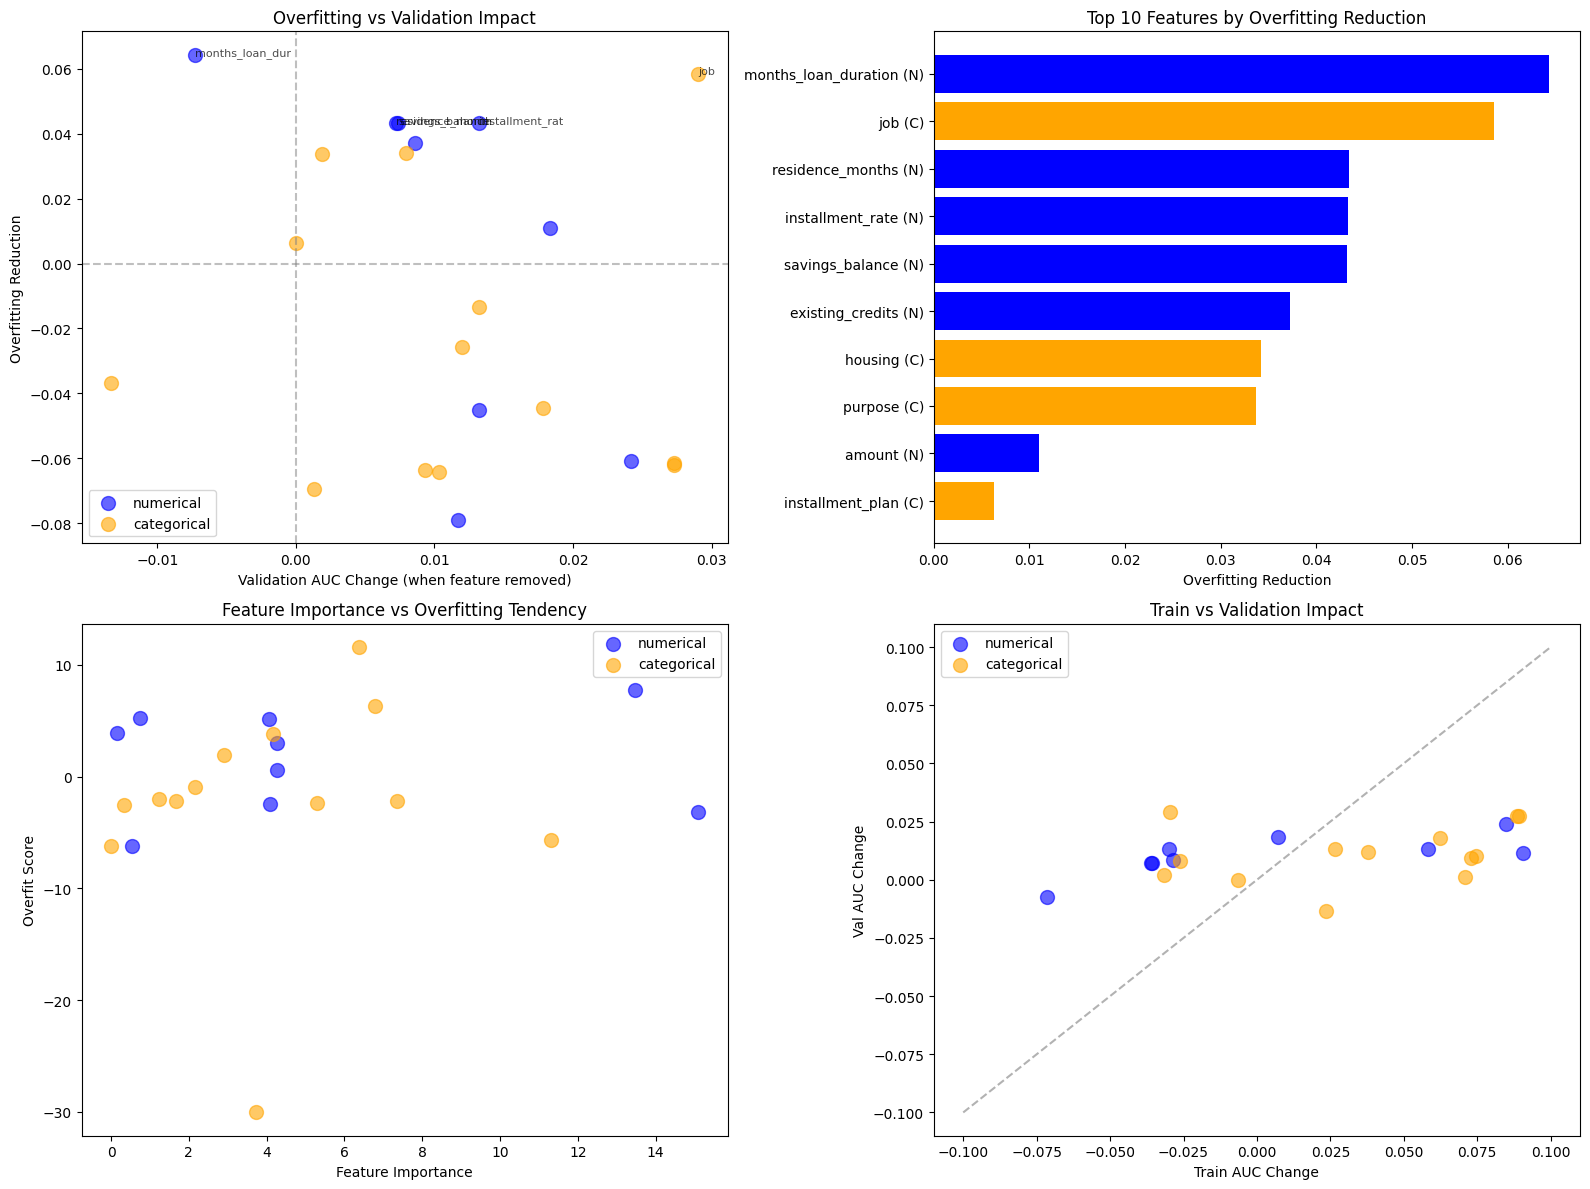

In [11]:
plot_overfitting_analysis(df_overfit, top_n=10)

## 7. Feature Selection

In [ ]:
# Remove weak and overfitting features
feat_cat_final = [
    "credit_history",
    "personal_status",
    "property",
    "installment_plan",
    "is_checking_negative",
]
feat_num_final = ["checking_balance", "amount", "savings_balance", "employment_months"]

print(
    f"✅ Selected features: {len(feat_cat_final)} categorical, {len(feat_num_final)} numerical"
)

# Create new pools
train_pool_v2 = Pool(
    data=df_train[feat_cat_final + feat_num_final],
    label=df_train[target],
    cat_features=feat_cat_final,
)
test_pool_v2 = Pool(
    data=df_test[feat_cat_final + feat_num_final],
    label=df_test[target],
    cat_features=feat_cat_final,
)
val_pool_v2 = Pool(
    data=df_val[feat_cat_final + feat_num_final],
    label=df_val[target],
    cat_features=feat_cat_final,
)

## 8. Train Final Model (Selected Features)

In [ ]:
results_final = train_catboost_model(
    train_pool=train_pool_v2, val_pool=val_pool_v2, test_pool=test_pool_v2, verbose=True
)

model_final = results_final["model"]
predictions = results_final["predictions"]
print("✅ Final model trained")

In [ ]:
analyze_feature_importance_cb(model=model_final, pool=train_pool_v2, top_n=10)

## 9. ROC-AUC Curves

In [ ]:
# ROC-AUC curve analysis and visualization
print("ROC-AUC Analysis and Visualization")
# Generate ROC curves with detailed analysis
plot_AUC(
    df_train[target],  # Train true labels
    predictions["train"],  # Train predictions
    df_val[target],  # Validation true labels
    predictions["val"],  # Validation predictions
    df_test[target],  # Test true labels
    predictions["test"],  # Test predictions
)

## 10. Precision-Recall Curves

In [ ]:
# Precision-Recall curve analysis and visualization
print("Precision-Recall Analysis and Visualization")
plot_PR(
    df_train[target],  # Train true labels
    predictions["train"],  # Train predictions
    df_test[target],  # Test true labels
    predictions["test"],  # Test predictions
    df_val[target],  # Validation true labels
    predictions["val"],  # Validation predictions
)

## Summary

✅ **Feature Selection**: Reduced from 22 to 9 features  
✅ **Overfitting Reduced**: Removed problematic features  
⏭️ **Next**: Hyperparameter optimization